# Лабораторная работа № 4. Статистический анализ данных о тепловой нагрузке блоков усиления мощности.

В работе проводится анализ данных о температуре и техническом состоянии совокупности блоков усиления мощности. Определяется взаимосвязь их технического состоянии с общим состоянием системы.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу. Под системой в этой работе мы будем понимать несколько БУМ, объединенных в единое целое. Тогда техническое состояние всей системы будет определяться техническим состоянием ее компонент, т.е. состоянием БУМ в данной работе. Техническое же состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача - спрогнозировать увеличение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков, который задает интенсивность нагрева, и возможный выход из строя всей системы блоков. Соответственно, необходимо определить критерий, на основании которого делается вывод о техническом состоянии системы, т.е. установить соответствие между состояниями блоков и состоянием системы. Именно этой задаче и будет посвящена данная лабораторная работа.

## Описание файла с данными

Подключим стандартные пакеты для работы с данными и построения графиков

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [2]:
df = pd.read_csv("Lab4_data.csv")
df.head()

,mode,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,system_state
0,3,28.286114,28.043155,27.282141,28.704673,26.530050,30.627461,29.912560,29.724531,29.358333,1.0
1,4,34.142434,35.346311,34.829661,35.079161,35.740529,38.070576,38.675433,36.362013,35.819681,1.0
2,2,34.813586,36.781106,34.445407,34.423135,35.091298,37.398229,38.883147,36.309084,35.741195,1.0
3,4,39.946499,43.133120,40.372435,39.102817,42.374502,41.829684,44.227679,42.699515,41.328171,1.0
4,4,43.950857,47.014358,44.162152,43.810740,45.837267,45.189761,47.661803,46.020946,46.441315,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   mode          1205950 non-null  int64  
 1   temp1         1205950 non-null  float64
 2   temp2         1205950 non-null  float64
 3   temp3         1205950 non-null  float64
 4   temp4         1205950 non-null  float64
 5   temp5         1205950 non-null  float64
 6   temp6         1205950 non-null  float64
 7   temp7         1205950 non-null  float64
 8   temp8         1205950 non-null  float64
 9   temp9         1205950 non-null  float64
 10  system_state  1205950 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 101.2 MB


Первая колонка **mode** обозначает номер режима работы блоков. Этот режим определяет интенсивность нагрева блоков. Следующие 9 колонок содержат в себе информацию о температуре каждого из 9-ти БУМ в каждый момент времени. Последняя колонка - бинарный признак работоспособности всей системы блоков.

## Определение температурных порогов отключения и включения блоков

Посмотрим на динамику температуры для каждого блока. Отчетливо видно, что существуют области почти линейного уменьшения температуры - периоды охлаждения блоков. В этом задании требуется определить температурные пороги, достижение которых приводит к отлючению блоков или, наоборот, к возврату их в работоспособное состояние. Также требуется сделать вывод о похожести блоков.

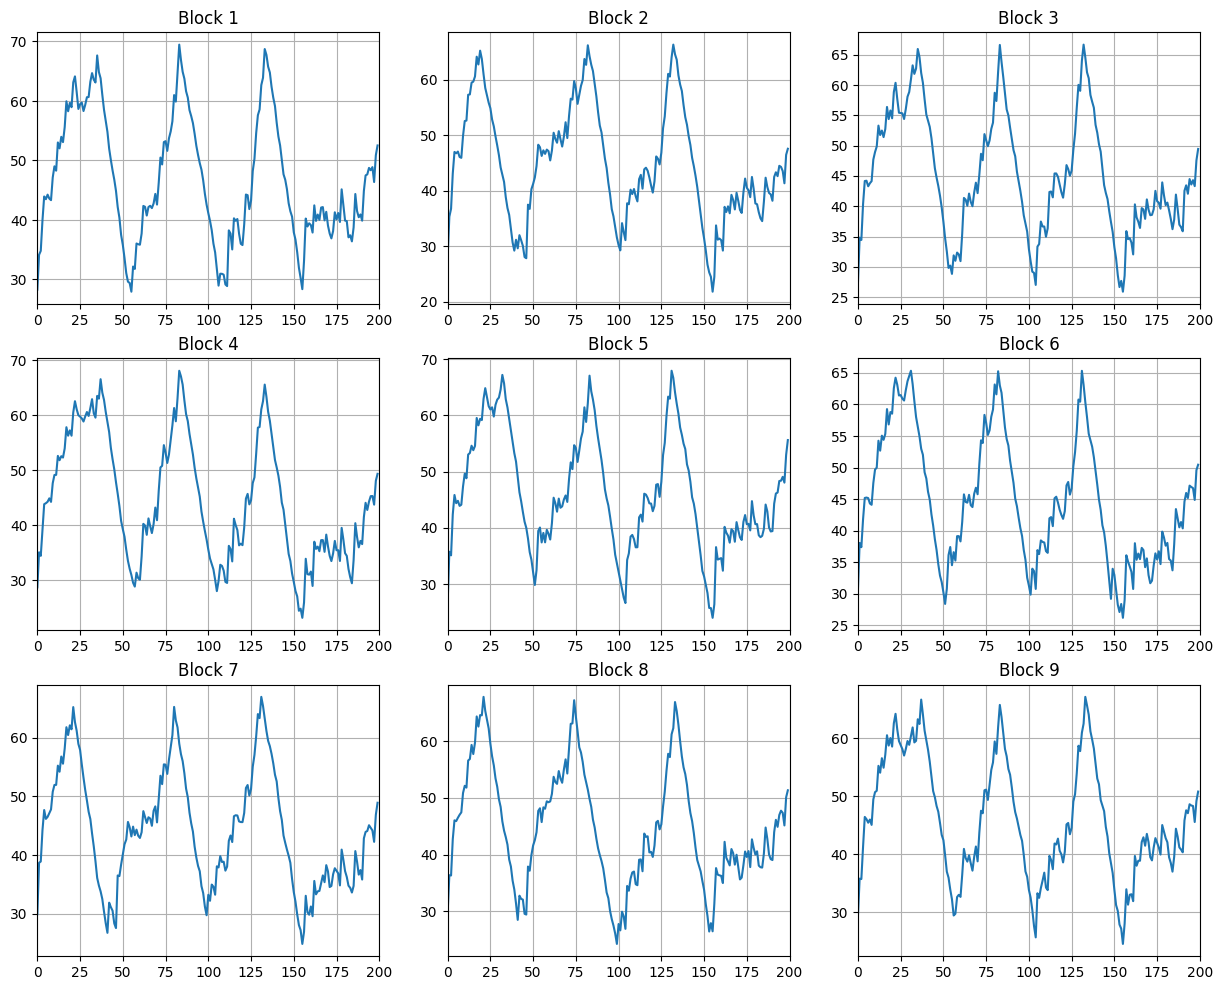

In [68]:
plt.figure(figsize=(15,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(range(200), df['temp'+str(i+1)][0:200])
    plt.xlim(0,200)
    plt.title('Block '+str(i+1))
    plt.grid(True)
plt.show()

#### **Задание 1** 

Напишите функцию, которая бы по данным о температуре для конкретного блока (тип **Series**) определяла области, в которых происходит охлаждение блока. Параметр **threshold** задает минимальную длительность такой области.

In [5]:
def find_decreasing_regions(series, threshold = 10):
    regions = []
    start = None
    
    for i in range(1, len(series)):
        if series[i] < series[i - 1]:
            if start is None:
                start = i - 1
        else:
            if start is not None:
                end = i - 1
                if end - start + 1 >= threshold:
                    regions.append((start, end))
                start = None
    
    # Check if the last region extends to the end
    if start is not None:
        end = len(series) - 1
        if end - start + 1 >= threshold:
            regions.append((start, end))
    
    return regions

Определим области охлаждения для каждого блока

In [51]:
threshold = 15

block_names = ['temp1','temp2','temp3','temp4','temp5','temp6','temp7','temp8','temp9']
decreasing_regions = [find_decreasing_regions(df[name], threshold) for name in block_names]

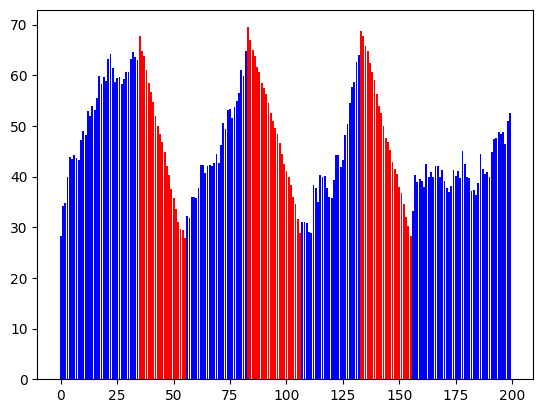

In [39]:
highlighted_indices = []

def is_number_in_regions(number, region):
    for start, end in region:
        if start <= number <= end:
            return True
    return False

y = []

# Создаем список сегментов для LineCollection
segments = []
colors = []
for i in range(200):
    val = df['temp1'][i]
    y.append(val)
    

# Создаем столбчатую диаграмму
plt.bar(range(200), y, color=['red' if is_number_in_regions(i, decreasing_regions[0]) else 'blue' for i in range(200)])

# Отображаем график
plt.show()

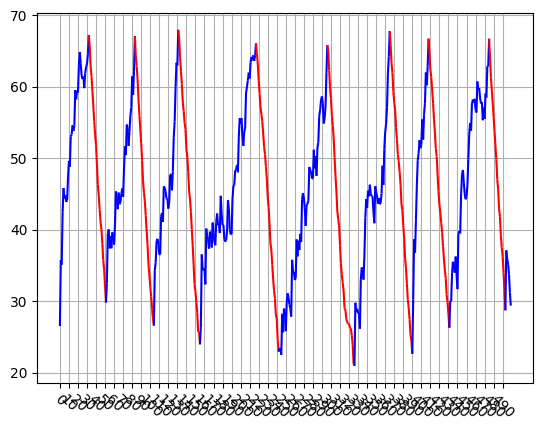

[(32, 51), (83, 104), (131, 155), (217, 242), (296, 326), (365, 390), (408, 431), (475, 493), (526, 544), (574, 593), (606, 625), (654, 674), (711, 736), (768, 789), (854, 877), (922, 943), (972, 993), (1074, 1095), (1127, 1145), (1194, 1212), (1300, 1320), (1350, 1370), (1433, 1454), (1479, 1501), (1548, 1565), (1598, 1619), (1680, 1700), (1737, 1755), (1791, 1812), (1882, 1904), (1926, 1946), (2005, 2024), (2060, 2081), (2151, 2174), (2199, 2218), (2237, 2257), (2290, 2315), (2357, 2381), (2426, 2444), (2492, 2510), (2551, 2574), (2619, 2641), (2677, 2700), (2759, 2778), (2830, 2847), (2866, 2885), (2928, 2949), (3011, 3028), (3066, 3084), (3106, 3126), (3177, 3194), (3232, 3253), (3330, 3352), (3380, 3400), (3455, 3478), (3516, 3535), (3580, 3602), (3651, 3672), (3701, 3726), (3814, 3833), (3912, 3930), (4014, 4035), (4059, 4080), (4129, 4150), (4195, 4214), (4244, 4270), (4292, 4316), (4341, 4364), (4419, 4440), (4480, 4499), (4543, 4565), (4598, 4619), (4675, 4697), (4744, 4764), 

In [80]:
from matplotlib.collections import LineCollection
block_names = ['temp1','temp2','temp3','temp4','temp5','temp6','temp7','temp8','temp9']

# INPUT
block_to_display = 'temp5'
x_max_limit = 500

block_index = block_names.index(block_to_display)
highlighted_indices = []

def is_number_in_regions(number, region):
    for start, end in region:
        if start <= number < end:
            return True
    return False

x = range(x_max_limit)
y = df[block_to_display]

# Создаем список сегментов для LineCollection
segments = []
colors = ['red' if is_number_in_regions(i, decreasing_regions[block_index]) else 'blue' for i in range(x_max_limit)]

for i in range(1, x_max_limit):
    segments.append([(x[i-1], y[i-1]), (x[i], y[i])])
    if is_number_in_regions(x[i-1], decreasing_regions[block_index]):
        colors.append('red')
    else:
        colors.append('blue')


# Создаем LineCollection
lc = LineCollection(segments, colors=colors, linewidth=1.5)

# Создаем график
fig, ax = plt.subplots()
ax.add_collection(lc)

# Настройка границ графика и меток
ax.autoscale()

# Отображаем график
plt.grid(True)
plt.xticks(range(min(x), max(x) + 1, 10))
plt.xticks(rotation=-45)
#plt.xlim(150,200)
plt.show()

print(decreasing_regions[block_index])

#### **Задание 2** 

Напишите функции, которые бы выдавали список значений температур, при которых произошло отключение блока и его повторное включение после охлаждения, для каждого блока.

In [101]:
def find_max_temp(regions, series):
    max_temp_indexes = [pair[0] for pair in regions]
    return [series[value] for value in max_temp_indexes]

def find_min_temp(regions, series):
    min_temp_indexes = [pair[1] for pair in regions]
    return [series[value] for value in min_temp_indexes]

Определим значения температур, при которых произошло отключение блоков и их повторное включение после охлаждения.

In [102]:
max_temp = [find_max_temp(decreasing_regions[i], df['temp'+str(i+1)]) for i in range(9)]
min_temp = [find_min_temp(decreasing_regions[i], df['temp'+str(i+1)]) for i in range(9)]

Примените функцию ниже к полученным значениям температур. Наглядно сравните распределение верхних и нижних порогов температур для каждого блока. На основании этих распределений сделайте вывод о похожести блоков.

In [136]:
def hist_min_max_temp(min_max_temp, size=(15,12)):
    plt.figure(figsize=size)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.hist(min_max_temp[i], bins=100)
        plt.title('Block '+str(i+1))
    plt.show()

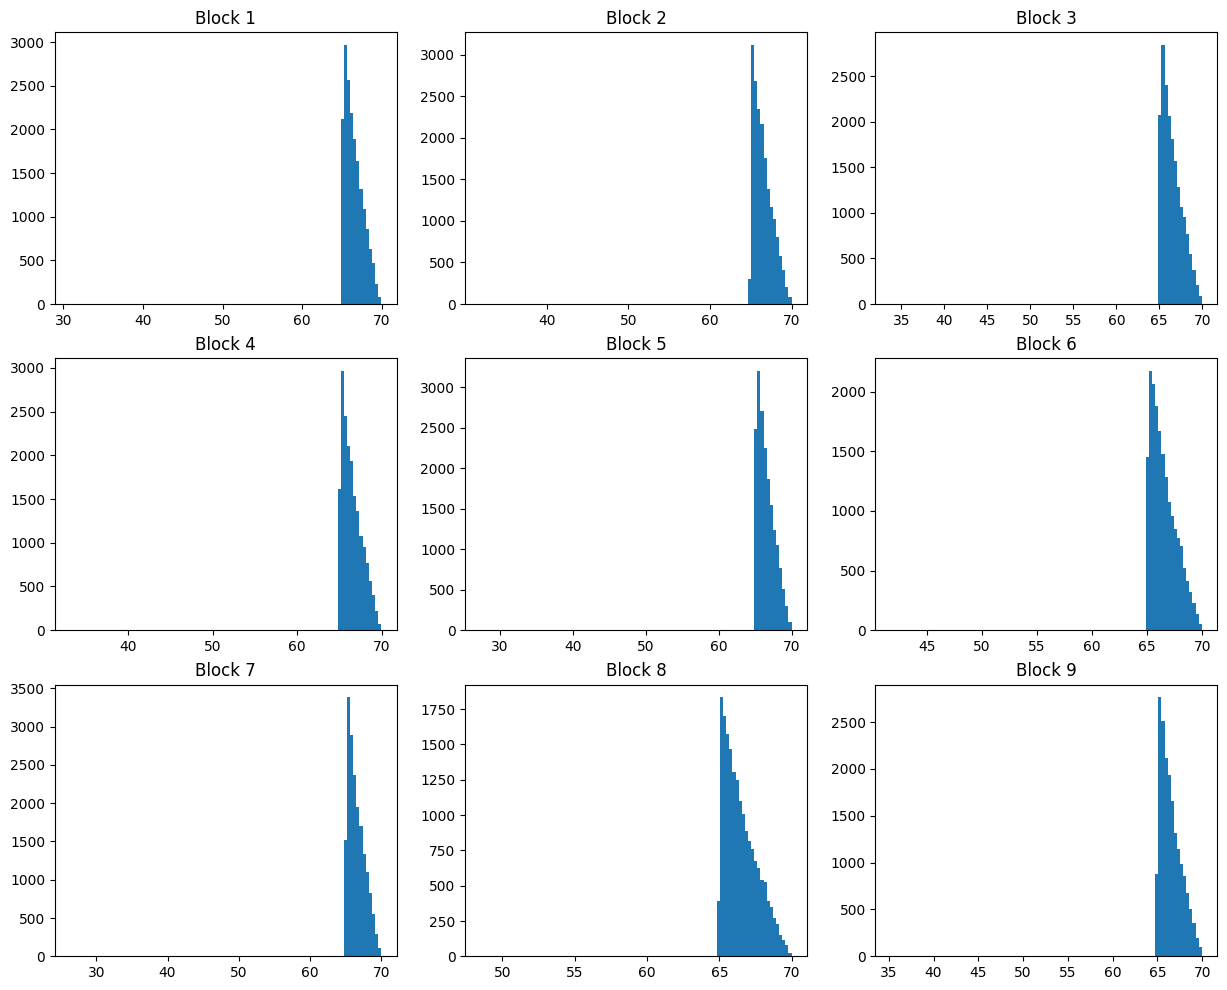

In [137]:
hist_min_max_temp(max_temp)

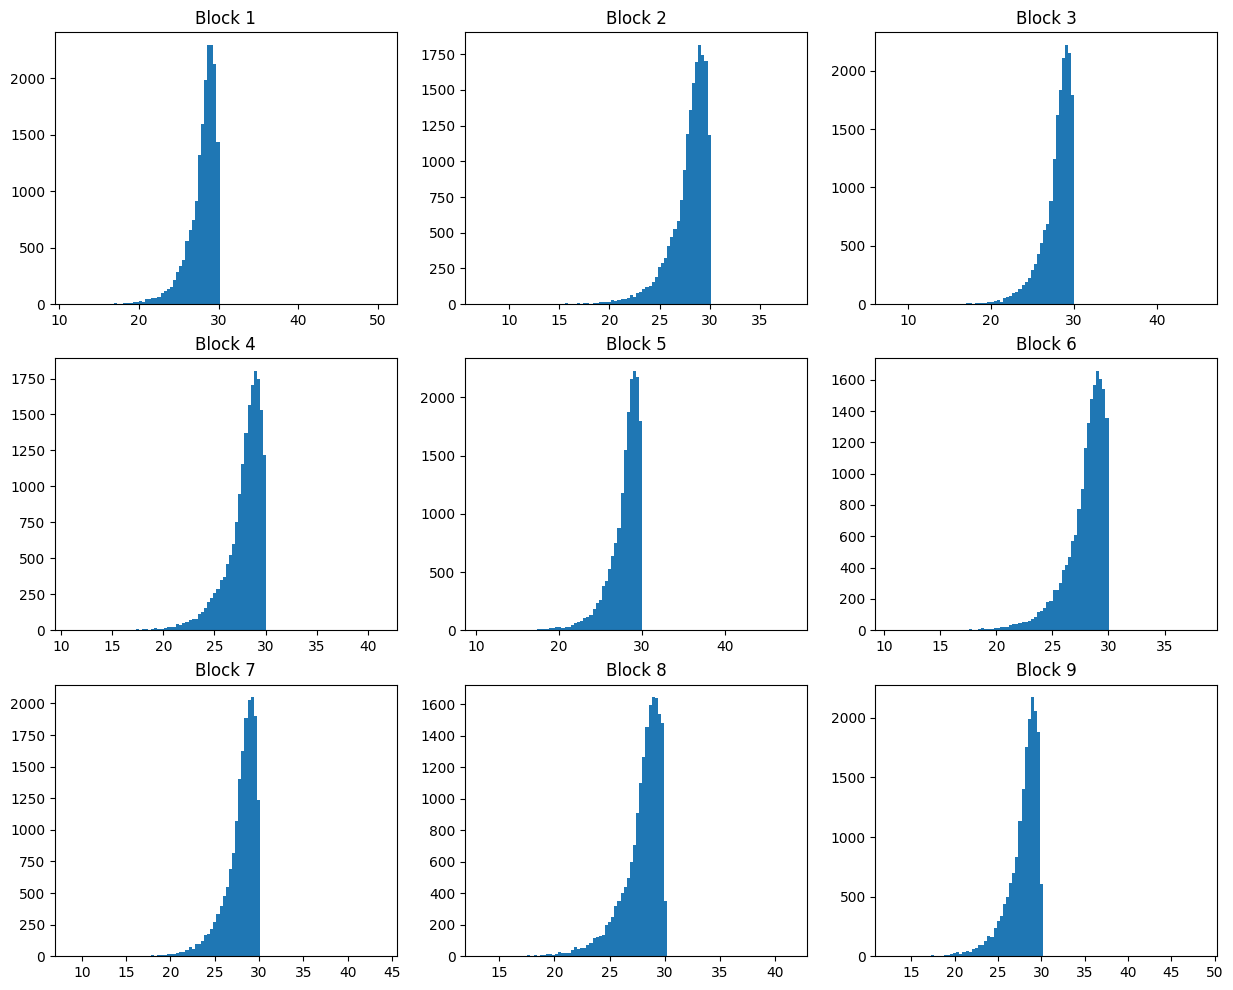

In [138]:
hist_min_max_temp(min_temp)

### Вывод:

Из гистограмм мы видим, что блоки имеют схожее распределение максимальных и минимальных температур, при которых происходит выключение и включение блока. Большинство значений температур отключения и включения лежат в пределах 65.5℃ и 29℃ соответственно. Исходя из полученных данных рабочий диапазон температуры устройств примерно (29-65)℃.

#### **Задание 3** 

Определите средние значения температурных порогов для каждого блока и всех блоков в целом.

In [13]:
mean_max_temp = [] # напишите свой код здесь
mean_min_temp = [] # напишите свой код здесь

print('Mean max_temp: ', mean_max_temp)
print('Mean min_temp: ', mean_min_temp)

Mean max_temp:  []
Mean min_temp:  []


In [14]:
max_temp_thres = 0 # напишите свой код здесь
min_temp_thres = 0 # напишите свой код здесь

print('Max_temp threshold: ', max_temp_thres)
print('Min_temp threshold: ', min_temp_thres)

Max_temp threshold:  0
Min_temp threshold:  0


## Определение технического состояния каждого блока

#### **Задание 4** 

Напишите функцию, которая бы по известной текущей температуре **temp**, верхнего **max_temp** и нижнего **min_temp** температурных порогов определяла состояние блока в диапазоне от 0 до 1 (0 - блок имеет нижнюю температуру, 1 - верхнюю). При этом значения температуры, выше верхнего порога должны соответствовать состоянию 0, а температуры, ниже нижнего порога - состоянию 1. 

In [15]:
def get_state(temp, max_temp, min_temp):
    
    # напишите свой код здесь
    
    return 0

#### **Задание 5** 

Добавьте в DataFrame новые столбцы 'state1' и т.д., содержащие состояния блоков. Учтите, что в те промежутки, когда блок остывает и находится в выключенном состоянии, его состояние должно быть равно 0.

In [16]:
for i in range(9):
    
    # напишите свой код здесь

SyntaxError: incomplete input (858068838.py, line 3)

Построим сравнительный график столбцов 'temp9' и 'state9' - проверим правильность перевода температуры в состояние.

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(df['temp9'])
plt.xlim(0,200)
plt.ylim(25,75)
plt.title('Temperature')
plt.subplot(2,1,2)
plt.plot(df['state9'])
plt.xlim(0,200)
plt.title('Technical state')
plt.show()

## Корреляции технического состояния блоков с состоянием системы

Построим друг над другом графики состояния системы и состояния блоков, чтобы определить возможную взаимосвязь этих величин.

In [ ]:
plt.figure(figsize=(10,20))
plt.subplot(10,1,1)
plt.plot(df['system_state'])
plt.xlim(0,500)
plt.xticks([])
plt.title('System state')
for i in range(9):
    plt.subplot(10,1,i+2)
    plt.plot(df['state'+str(i+1)])
    plt.xlim(0,500)
    if i < 8:
        plt.xticks([])
    plt.title('Technical state '+str(i+1))
plt.show()

Наглядно видно, что состояние системы становится равным 0, когда какая-то часть блоков отключается и начинает охлаждаться. Поскольку блоки идентичные, то можно предположить, что каждый из них одинаковым образом влияет на состояния системы. Поэтому определим взаимосвязь состояния системы со средним значением состояния блоков.

#### **Задание 6** 

Определите среднее состояние блоков с помощью метода **pd.DataFrame.agg()**.

In [ ]:
sum_state = 0 # напишите свой код здесь

Сравним на графиках состояние системы и среднее состояние блоков.

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(df['system_state'])
plt.xlim(0,500)
plt.xticks([])
plt.title('System state')
plt.subplot(2,1,2)
plt.plot(sum_state)
plt.xlim(0,500)
plt.title('Sum block state')
plt.show()

#### **Задание 7** 

Для того, чтобы по состоянию блоков можно было определять состояние системы, нужно выбрать пороговое значение состояния блоков, выше которого состояние системы будет прогнозироваться равным 1, а ниже - равным 0. Сделаем это обычным перебором. Но для начала приведем значения состояния системы либо к значению 0, либо к значению 1.

Напишите функцию, которая будет рассчитывать точность соответствия состояния системы **system_state** и среднего состояния блоков **sum_state** для определенного порогового значения **threshold**. Точность - относительное число точных совпадений состояний блоков и системы (1 и 1 или 0 и 0).

In [ ]:
system_state = np.ones(len(df))
system_state[df['system_state'] < 0.5] = 0.

In [ ]:
def accuracy(system_state, sum_state, threshold):
    
    # напишите свой код здесь
    
    return 0

#### **Задание 8** 

Определим точность для каждого значения порога в интервале от 0 до 1.

In [ ]:
acc = []
thresholds = np.linspace(0., 1., num = 100)

for thres in thresholds:
    
    # напишите свой код здесь

Построим график зависимости точности от порога. На графике виден максимум, соответствующий оптимальному значению порога.

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(thresholds, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

#### **Задание 9** 

Определите максимальное значение точности и оптимальное значение порога.

In [ ]:
max_accuracy = 0 # напишите свой код здесь
optimal_threshold = 0 # напишите свой код здесь

print('Maximum accuracy {:.3f} for the threshold {:.3f}'.format(max_accuracy, optimal_threshold))

## Выводы

#### **Задание 10** 

Напишите ниже выводы по результатам лабораторной работы.